In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### 1.	What scale of measurement applies to timeseries data? Is timeseries data continuous or discrete? Why?

- Timeseries data is measured on regularly spaced interval of time.
- Timeseries data can be both contious and discrete
- A time series is continuous when observations are made continuously through time
- A time series is discrete when observations are taken only at specific times, usually equally spaced, even the
  measured variable is a continuous variable.

### 2.	What does ARIMA stand for? Break down and explain each piece in the name.

ARIMA stands for AutoRegressive Integrated Moving Average.
- AR (Autoregression): A model that uses the dependent relationship between an observation and some number of lagged observations
- I (Integrated): A model that uses the differencing of raw observations (e.g. subtracting an observation from the previous time step). Differencing in statistics is a transformation applied to time-series data in order to make it stationary. It eliminates trend and seasonality and stabilizing the mean of the time series.
- MA (Moving Average): A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations

### 3.	Using the data in the temperatures/ folder. Write a function that efficiently converts every column to a different temperature scale: one that is more common than Kelvin.

In [2]:
#parse datetime & set index to datetime
df=pd.read_csv('temperatures/temperature.csv',parse_dates=['datetime'],index_col=['datetime'])
df.head(2)

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.10,NaN,NaN,NaN
2012-10-01 13:00:00,284.63,282.08,289.48,281.8,291.87,291.53,293.41,296.6,285.12,284.61,...,285.63,288.22,285.83,287.17,307.59,305.47,310.58,304.4,304.4,303.5


In [3]:
#lambda function
celsius_df=df.apply(lambda x: x - 273.15)
celsius_df.head(3)

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.950000,NaN,NaN,NaN
2012-10-01 13:00:00,11.480000,8.930000,16.330000,8.650000,18.720000,18.380000,20.260000,23.450000,11.970000,11.460000,...,12.480000,15.070000,12.68000,14.020000,34.44,32.32,37.430000,31.25,31.25,30.35
2012-10-01 14:00:00,11.479041,8.933252,16.324993,8.647217,18.718186,18.383501,20.253141,23.458508,12.004558,11.457306,...,12.513208,15.097676,12.68465,14.036092,34.44,31.16,37.345769,31.25,31.25,30.35


### 4.	Write a function that efficiently fills in missing values in every column, excluding trailing NANs. That is: if there's temperature data on either side of a timestamp, it should interpolate through it. But if data stopped being collected, your function should leave nans at the end.

In [4]:
def fill_nans(celsius_df):
    return celsius_df.interpolate(axis=0, method='linear', limit_area='inside') 

celsius_df = fill_nans(celsius_df)
celsius_df.tail(5)

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,8.85,NaN,7.67,20.40,19.00,16.39,21.56,12.57,16.41,...,17.09,NaN,1.98,14.93,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,9.74,NaN,8.50,22.53,19.59,17.46,22.44,13.30,17.55,...,16.09,NaN,0.98,12.87,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,10.24,NaN,9.60,22.81,19.43,18.19,23.10,13.29,16.56,...,13.63,NaN,0.33,10.79,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,9.87,NaN,9.81,22.50,19.46,19.00,24.00,12.99,16.02,...,11.42,NaN,-0.67,9.02,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,9.13,NaN,9.89,21.78,18.25,18.49,24.00,11.55,12.03,...,10.27,NaN,-1.35,7.50,NaN,NaN,NaN,NaN,NaN,NaN


### 5.	Find all cities A and B where city A is warmer than city B in the summer, but also colder than city B in the winter, on average.

In [5]:
# March to August - Summer
# September to Feb - Winter
#applies in order
conditions = [
    (celsius_df.index.month>=9),
    (celsius_df.index.month<=2),
    (celsius_df.index.month>2),
    (celsius_df.index.month<9),
]
values = ['winter', 'winter', 'summer', 'summer']
celsius_df['season'] = np.select(conditions, values)

In [6]:
#check if the conditions applied in order
celsius_df["season"].sample(10) 

datetime
2016-06-27 04:00:00    summer
2017-07-09 18:00:00    summer
2014-05-15 09:00:00    summer
2017-08-09 21:00:00    summer
2015-08-30 04:00:00    summer
2016-05-31 16:00:00    summer
2017-11-27 00:00:00    winter
2015-12-05 03:00:00    winter
2015-03-14 01:00:00    summer
2014-06-10 19:00:00    summer
Name: season, dtype: object

In [7]:
season_grp_avg = celsius_df.groupby('season').mean()
season_grp_avg

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
season,,,,,,,,,,,,,,,,,,,,,
summer,14.128676,15.388533,16.609003,14.441651,19.539008,18.519890,25.249739,27.403236,17.654461,14.531462,...,17.013093,16.751792,12.675939,14.711171,21.320387,23.633938,27.008922,24.048914,22.785912,22.759145
winter,7.341951,8.464415,13.424129,8.228979,15.939411,15.678759,13.581605,17.520636,7.525674,5.075537,...,7.659853,7.809360,1.967683,6.739667,15.462265,19.121127,19.734876,20.208544,19.126797,17.345889


In [8]:
cities = {"A":[],"B":[]}

for i in range(len(season_grp_avg.columns)):
    for j in range(i+1,len(season_grp_avg.columns)): 
        if season_grp_avg.iloc[0,i]>season_grp_avg.iloc[0,j] and season_grp_avg.iloc[1,i]<season_grp_avg.iloc[1,j]:
            cities["A"].append(season_grp_avg.columns[i])
            cities["B"].append(season_grp_avg.columns[j])
            
combined=pd.DataFrame(cities)
combined

,A,B
0,Las Vegas,San Antonio
1,Las Vegas,Dallas
2,Las Vegas,Houston
3,Las Vegas,Jacksonville
4,Las Vegas,Beersheba
5,Las Vegas,Tel Aviv District
6,Las Vegas,Haifa
7,Las Vegas,Nahariyya
8,Las Vegas,Jerusalem
9,Phoenix,Houston


### 6.	For two of the cities you found in question 5 (there are many possible answers), clean up the data via rolling averages and plot a clear visual. Explain how rolling average differs from moving average (MA) model.

In [9]:
two_cities = celsius_df.loc[:,['Detroit','Boston']]
two_cities.tail(2)

,Detroit,Boston
datetime,,
2017-11-29 23:00:00,4.91,9.02
2017-11-30 00:00:00,3.44,7.50


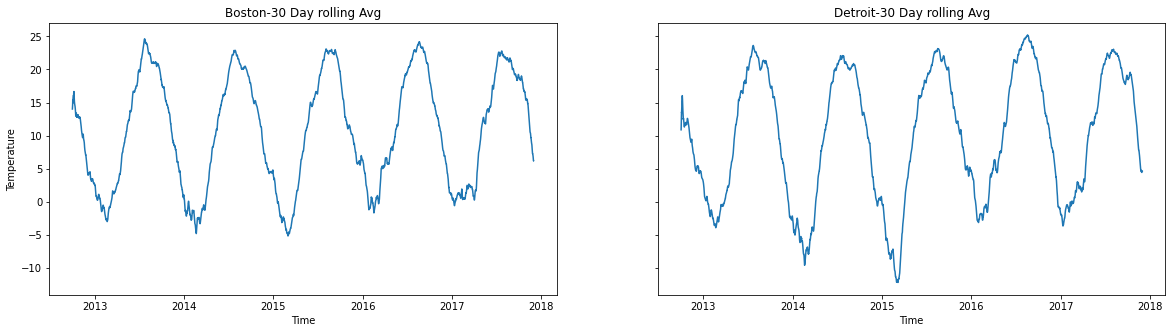

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, sharey=True,figsize=(20,5))

ax[0].plot(two_cities.index, two_cities["Boston"].rolling('30D').mean())
ax[1].plot(two_cities.index, two_cities["Detroit"].rolling('30D').mean())
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Temperature')
ax[0].set_title('Boston-30 Day rolling Avg')
ax[1].set_title('Detroit-30 Day rolling Avg')
plt.show()

A rolling average continuously updates the average of a data set to include all the data in the set until that point.
A moving average calculates the average of a data set for a specified period

### 7.	Perform SARIMA on five cities, iterating through the cities programmatically. Explain your results.
a.	Graph the predicted values 30 days out.


In [22]:
five_cities = celsius_df.loc[:,['New York','Boston','Detroit','Philadelphia','Las Vegas']]
five_cities = five_cities.resample('D').mean().dropna()
five_cities.isna().sum()

New York        0
Boston          0
Detroit         0
Philadelphia    0
Las Vegas       0
dtype: int64

for i in cities_pct:
        plot_acf(cities_pct[[i]], lags = 30,missing="drop",title="ACF-"+i)
        plot_pacf(cities_pct[[i]], zero = False, lags = 30,title="PACF-"+i)

In [17]:
resDiff = sm.tsa.arma_order_select_ic(five_cities.Boston, ic='bic')
print('ARMA(p,q) =',resDiff['bic_min_order'])

ARMA(p,q) = (2, 2)


In [18]:
summary=[]

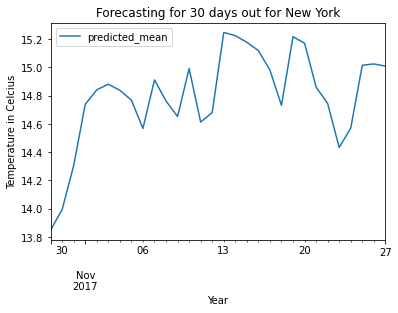

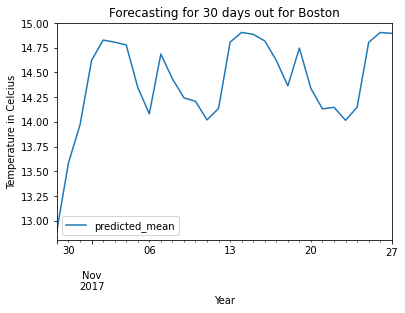

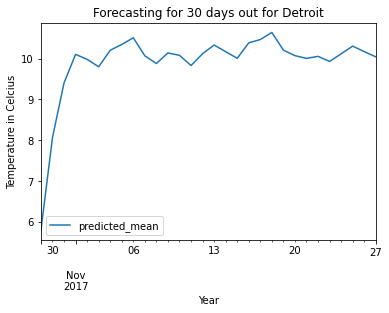

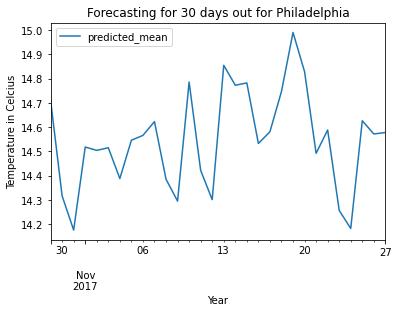

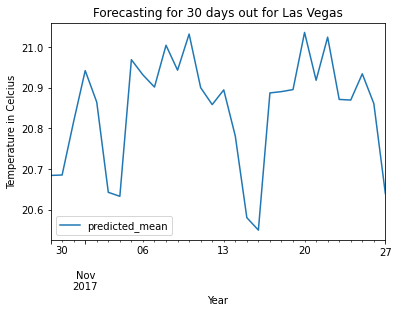

In [19]:
for i in five_cities:
    model = SARIMAX(five_cities[i], order=(2,1,2), seasonal_order=(2,1,2,12))
    res = model.fit()
    #forecasting for next 30 days
    forecast_df=pd.DataFrame(res.forecast(steps=30))
    summary.append(res.summary())
    forecast_df.plot()
    plt.title("Forecasting for 30 days out for "+i)
    plt.xlabel('Year')
    plt.ylabel('Temperature in Celcius')

- The temperature is seen decreasing overall towards the end of the month.
- The temperature is seen slowly decreasing in New York and Boston
- Philadelphia and Las Vegas has the most variability in the temperature.
- The temperature in Detroit seem to increasing but it is the coldest city out of all the chosen.

In [20]:
for i in summary:
    print(i)

                                     SARIMAX Results                                      
Dep. Variable:                           New York   No. Observations:                 1854
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -4631.993
Date:                            Thu, 09 Dec 2021   AIC                           9281.987
Time:                                    17:26:21   BIC                           9331.649
Sample:                                10-01-2012   HQIC                          9300.298
                                     - 10-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3144      0.066      4.743      0.000       0.184       0.444
ar.L2          0.0349      0.055   

### 8.	Explain what you see when you perform results.summary() on the cities in question 7. 

The p-value is less than 0.05 for ar.L1 for all the cities
AIC & BIC are in the same range for all the cities

### What do GARCH and ARCH Stand for? Break down and explain each piece in the names. Explain the difference between the two. 

- ARCH and GARCH models have become important tools in the analysis of time series data, particularly in financial applications

- An ARCH (autoregressive conditionally heteroscedastic) model is a model for the variance of a time series. ARCH models are used to describe a changing, possibly volatile variance

- Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.